In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [29]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS =3
EPOCHS =40

In [10]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Detection_dataset',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE

)

Found 2183 files belonging to 19 classes.


In [11]:
class_names= dataset.class_names
class_names

['APPLE_ ROT_LEAVES',
 'APPLE_HEALTHY_LEAVES',
 'APPLE_LEAF_ BLOTCH',
 'APPLE_SCAB_LEAVES',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

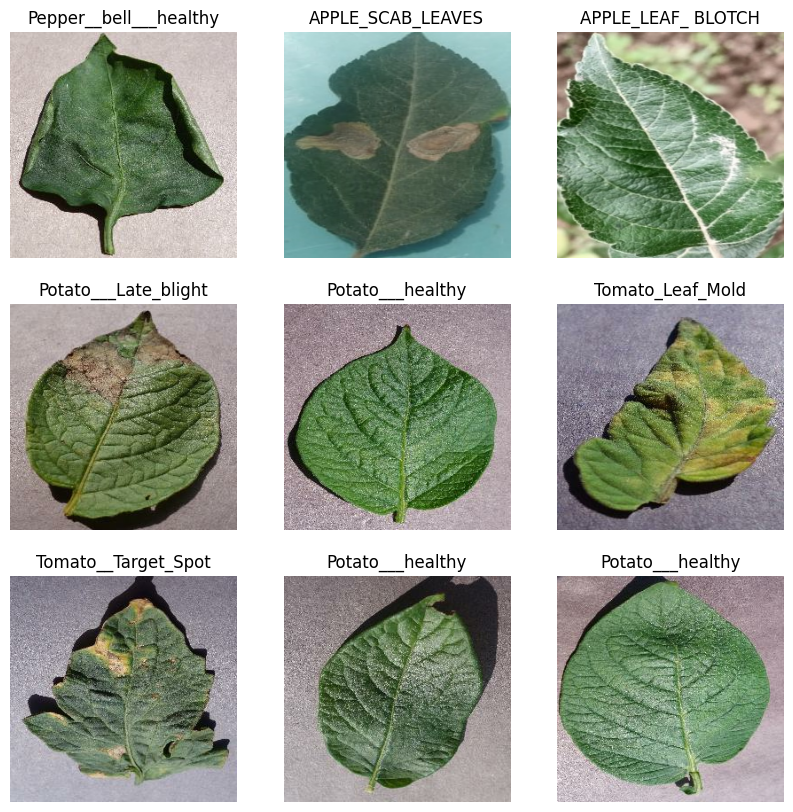

In [12]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
     for i in range (9):
            ax = plt.subplot(3,3,i+1)
            plt.imshow(image_batch[i].numpy().astype("uint8"))
            plt.title(class_names[labels_batch[i]])
            plt.axis("off")

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:

def random_crop_and_random_augmentations_fn(image):
  # preprocess_for_train does random crop and resize internally.
  image = tf.image.random_brightness(image, 0.2)
  image = tf.image.random_contrast(image, 0.5, 2.0)
  image = tf.image.random_saturation(image, 0.75, 1.25)
  image = tf.image.random_hue(image, 0.1)
  return image



def resize_and_center_crop_fn(image):
  image = tf.image.resize(image, (256, 256))
  image = image[16:240, 16:240]
  return image


no_augment_fn = lambda image: image

train_augment_fn = lambda image, label: (
    random_crop_and_random_augmentations_fn(image), label)
eval_augment_fn = lambda image, label: (resize_and_center_crop_fn(image), label)

In [17]:
train_ds = train_ds.map(train_augment_fn)

In [18]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [19]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 19

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [22]:
import os

In [23]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
    callbacks = [cp_callback]
)

Epoch 1/10
55/55 [==============================] - ETA: 0s - loss: 2.8885 - accuracy: 0.0968
Epoch 1: saving model to training_1/cp.ckpt
55/55 [==============================] - 254s 5s/step - loss: 2.8885 - accuracy: 0.0968 - val_loss: 2.8122 - val_accuracy: 0.1198
Epoch 2/10
55/55 [==============================] - ETA: 0s - loss: 2.8127 - accuracy: 0.1378
Epoch 2: saving model to training_1/cp.ckpt
55/55 [==============================] - 239s 4s/step - loss: 2.8127 - accuracy: 0.1378 - val_loss: 2.7846 - val_accuracy: 0.1094
Epoch 3/10
55/55 [==============================] - ETA: 0s - loss: 2.7136 - accuracy: 0.1464
Epoch 3: saving model to training_1/cp.ckpt
55/55 [==============================] - 239s 4s/step - loss: 2.7136 - accuracy: 0.1464 - val_loss: 2.6434 - val_accuracy: 0.1615
Epoch 4/10
55/55 [==============================] - ETA: 0s - loss: 2.6679 - accuracy: 0.1695
Epoch 4: saving model to training_1/cp.ckpt
55/55 [==============================] - 232s 4s/step - lo

In [30]:
os.listdir(checkpoint_dir)

['cp.ckpt.index', 'checkpoint', 'cp.ckpt.data-00000-of-00001']

In [31]:
model.build(input_shape=input_shape)
loss, acc = model.evaluate(test_ds, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

8/8 - 13s - loss: 1.6609 - accuracy: 0.4589 - 13s/epoch - 2s/step
Untrained model, accuracy: 45.89%


In [32]:
model.load_weights(checkpoint_path)

In [33]:
loss, acc = model.evaluate(test_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

8/8 - 9s - loss: 1.6609 - accuracy: 0.4589 - 9s/epoch - 1s/step
Restored model, accuracy: 45.89%


In [35]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = '/content/drive/MyDrive/CNN_MODEL/training_2/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 32

# Calculate the number of batches per epoch
import math
n_batches = len(train_ds) / batch_size
n_batches = math.ceil(n_batches)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*n_batches)

model.build(input_shape=input_shape)

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    callbacks=[cp_callback],
    validation_data=val_ds,
    verbose=1,
    epochs=40,
)

Epoch 1/40
 9/55 [===>..........................] - ETA: 3:06 - loss: 1.5420 - accuracy: 0.4601
Epoch 1: saving model to /content/drive/MyDrive/CNN_MODEL/training_2/cp-0001.ckpt
19/55 [=========>....................] - ETA: 2:35 - loss: 1.5873 - accuracy: 0.4666
Epoch 1: saving model to /content/drive/MyDrive/CNN_MODEL/training_2/cp-0001.ckpt
29/55 [==============>...............] - ETA: 1:52 - loss: 1.6149 - accuracy: 0.4618
Epoch 1: saving model to /content/drive/MyDrive/CNN_MODEL/training_2/cp-0001.ckpt
39/55 [====================>.........] - ETA: 1:09 - loss: 1.6585 - accuracy: 0.4448
Epoch 1: saving model to /content/drive/MyDrive/CNN_MODEL/training_2/cp-0001.ckpt
49/55 [=========================>....] - ETA: 25s - loss: 1.6782 - accuracy: 0.4407
Epoch 1: saving model to /content/drive/MyDrive/CNN_MODEL/training_2/cp-0001.ckpt
55/55 [==============================] - 246s 4s/step - loss: 1.6563 - accuracy: 0.4524 - val_loss: 1.6671 - val_accuracy: 0.4635
Epoch 2/40
 4/55 [=>.....

In [36]:
# Save the weights
model.save_weights('/content/drive/MyDrive/CNN_MODEL/checkpoints/my_checkpoint')

# Create a new model instance
model.build(input_shape=input_shape)

# Restore the weights
model.load_weights('/content/drive/MyDrive/CNN_MODEL/checkpoints/my_checkpoint')

# Evaluate the model
loss, acc = model.evaluate(test_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

8/8 - 14s - loss: 0.8407 - accuracy: 0.8701 - 14s/epoch - 2s/step
Restored model, accuracy: 87.01%


In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

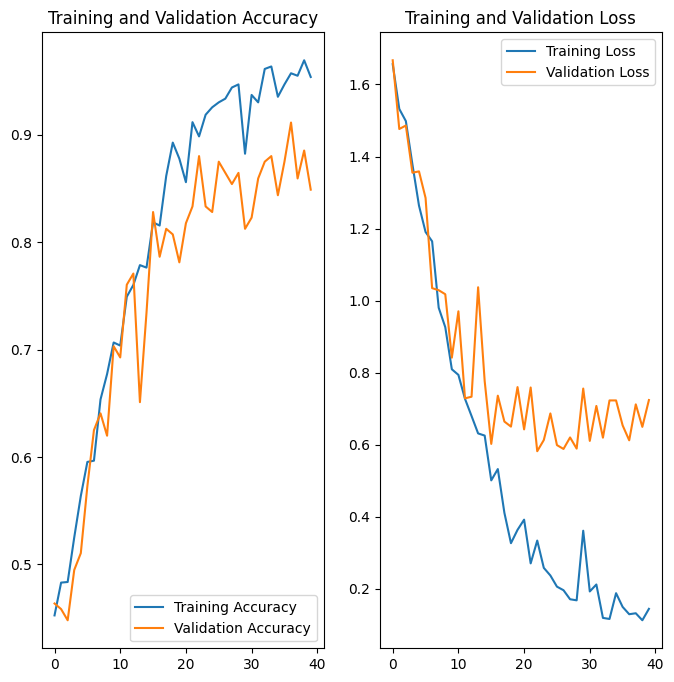

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
!pip install tensorflow --upgrade
!pip install keras --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 85.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 78.5 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled tensorboard-data-server

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 2s 2s/step
predicted label: Potato___Early_blight


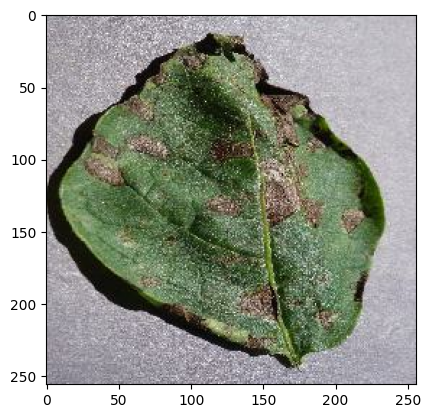

In [39]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

In [42]:

# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('/content/drive/MyDrive/CNN_MODEL/saved_model/my_model') 

In [43]:
# my_model directory
!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

ls: cannot access 'saved_model/my_model': No such file or directory


In [45]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/CNN_MODEL/saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)       

In [46]:
# Evaluate the restored model
loss, acc = new_model.evaluate(test_ds, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

8/8 - 8s - loss: 0.8407 - accuracy: 0.8701 - 8s/epoch - 1s/step
Restored model, accuracy: 87.01%


In [47]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('/content/drive/MyDrive/CNN_MODEL/my_model.h5') 

In [48]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('/content/drive/MyDrive/CNN_MODEL/my_model.h5')

# Show the model architecture
new_model.summary()

loss, acc = new_model.evaluate(test_ds, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)       